# Plots the Foreground and Background Spectra after Separating the Lens

In [1]:
# imports
import os
import numpy as np
import fitsio
import matplotlib.pyplot as plt
import seaborn as sb

from astropy.table import Table

In [2]:
# Set some plotting environment variables
sb.set(style='white', context='notebook', palette='Set1')
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.dpi"] = 200
plt.rcParams["axes.grid.which"] = 'both'
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 4
plt.rcParams['ytick.major.size'] = 4
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2

In [143]:
def plotDesiSpectra(coaddPath=None, spectra=None, smooth=True, ax=None, **kwargs):
    '''
    Plots desi spectra from a coadd file
    
    coaddSpec [desispec] : desispec spectra object to plot
    '''
    from desispec.io import read_spectra
    from astropy.convolution import convolve, Gaussian1DKernel
    
    if not coaddPath:
        coaddSpec = spectra
    if not spectra:
        coaddSpec = read_spectra(coaddPath)
    else:
        raise IOError('Please provide either a coadd path or spectra object')
    
    if not ax:
        fig, ax = plt.subplots(figsize = (20, 6))
    
    # Plot the spectrum from each arm (B,R,Z) in blue, green, red
    ax.plot(coaddSpec.wave['b'], coaddSpec.flux['b'][0], color = 'b', alpha = 0.5)
    ax.plot(coaddSpec.wave['r'], coaddSpec.flux['r'][0], color = 'g', alpha = 0.5)
    ax.plot(coaddSpec.wave['z'], coaddSpec.flux['z'][0], color = 'r', alpha = 0.5)
    
    if smooth:    
        # Over-plotting smoothed spectra in black for all the three arms
        ax.plot(coaddSpec.wave['b'], convolve(coaddSpec.flux['b'][0], Gaussian1DKernel(5)), color = 'k')
        ax.plot(coaddSpec.wave['r'], convolve(coaddSpec.flux['r'][0], Gaussian1DKernel(5)), color = 'k')
        ax.plot(coaddSpec.wave['z'], convolve(coaddSpec.flux['z'][0], Gaussian1DKernel(5)), color = 'k')
    
    ax.set_xlim([3500, 9900])
    ax.set_xlabel('$\lambda$ [$\AA$]')
    ax.set_ylabel('F$_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
    
    return coaddSpec

In [144]:
outdir = '/global/cfs/cdirs/desi/users/nrfran/speclens/'

INFO:spectra.py:291:read_spectra: iotime 0.041 sec to read coadd-sv3-bright-25964-out.fits at 2022-11-16T12:08:45.296592


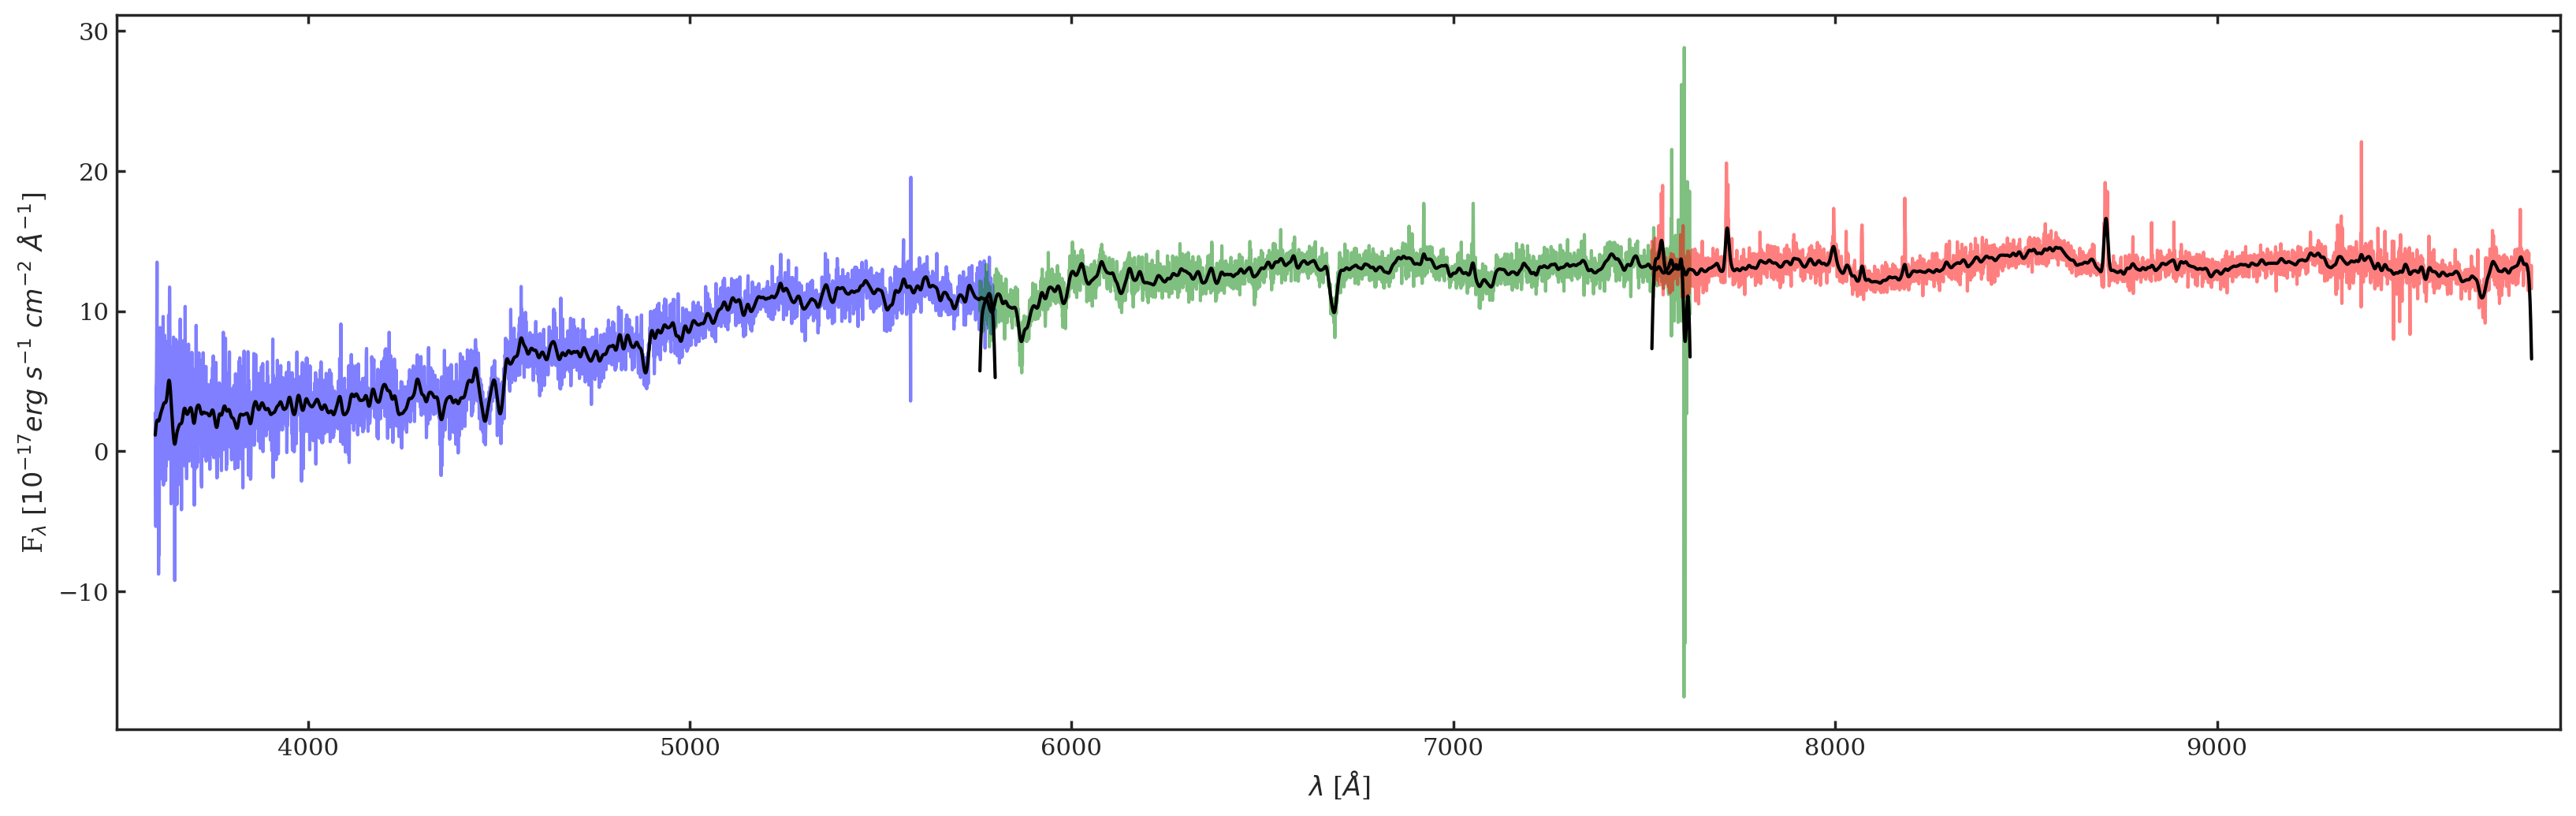

In [145]:
# plot the original spectrum
orig = os.path.join(outdir, 'coadd-sv3-bright-25964-out.fits')
coaddSpec = plotDesiSpectra(orig)

## First Foreground

In [146]:
def plotFastspecModel(fastfile, coaddPath, ax=None):
    '''
    Function to plot the fastspecfit model over the original spectrum
    '''
    from astropy.table import Table
    import fitsio
    from desispec.io import read_spectra
    
    # read in fastspecfit model
    model = Table(fitsio.read(fastfile, ext=3))
    flux = model['col0'].data[0]
    wave = np.linspace(3600.0, 9824.0, len(flux))
    
    if not ax:
        fig, ax = plt.subplots(figsize=(20,6))
        
    # read in a plot original coadded spectrum in the background
    coaddSpec = read_spectra(coaddPath)
    ax.plot(coaddSpec.wave['b'], coaddSpec.flux['b'][0], color = 'k', alpha = 0.5)
    ax.plot(coaddSpec.wave['r'], coaddSpec.flux['r'][0], color = 'k', alpha = 0.5)
    ax.plot(coaddSpec.wave['z'], coaddSpec.flux['z'][0], color = 'k', alpha = 0.5, label='Spectroscopic Lens')
    
    # plot fastspecfit model
    ax.plot(wave, flux, 'r-', label='fastspecfit Model')
    
    ax.set_xlim([3500, 9900])
    ax.set_xlabel('$\lambda$ [$\AA$]')
    ax.set_ylabel('F$_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
    ax.legend()
    
    return wave, flux

INFO:spectra.py:291:read_spectra: iotime 0.018 sec to read coadd-sv3-bright-25964-out.fits at 2022-11-16T12:08:55.254752


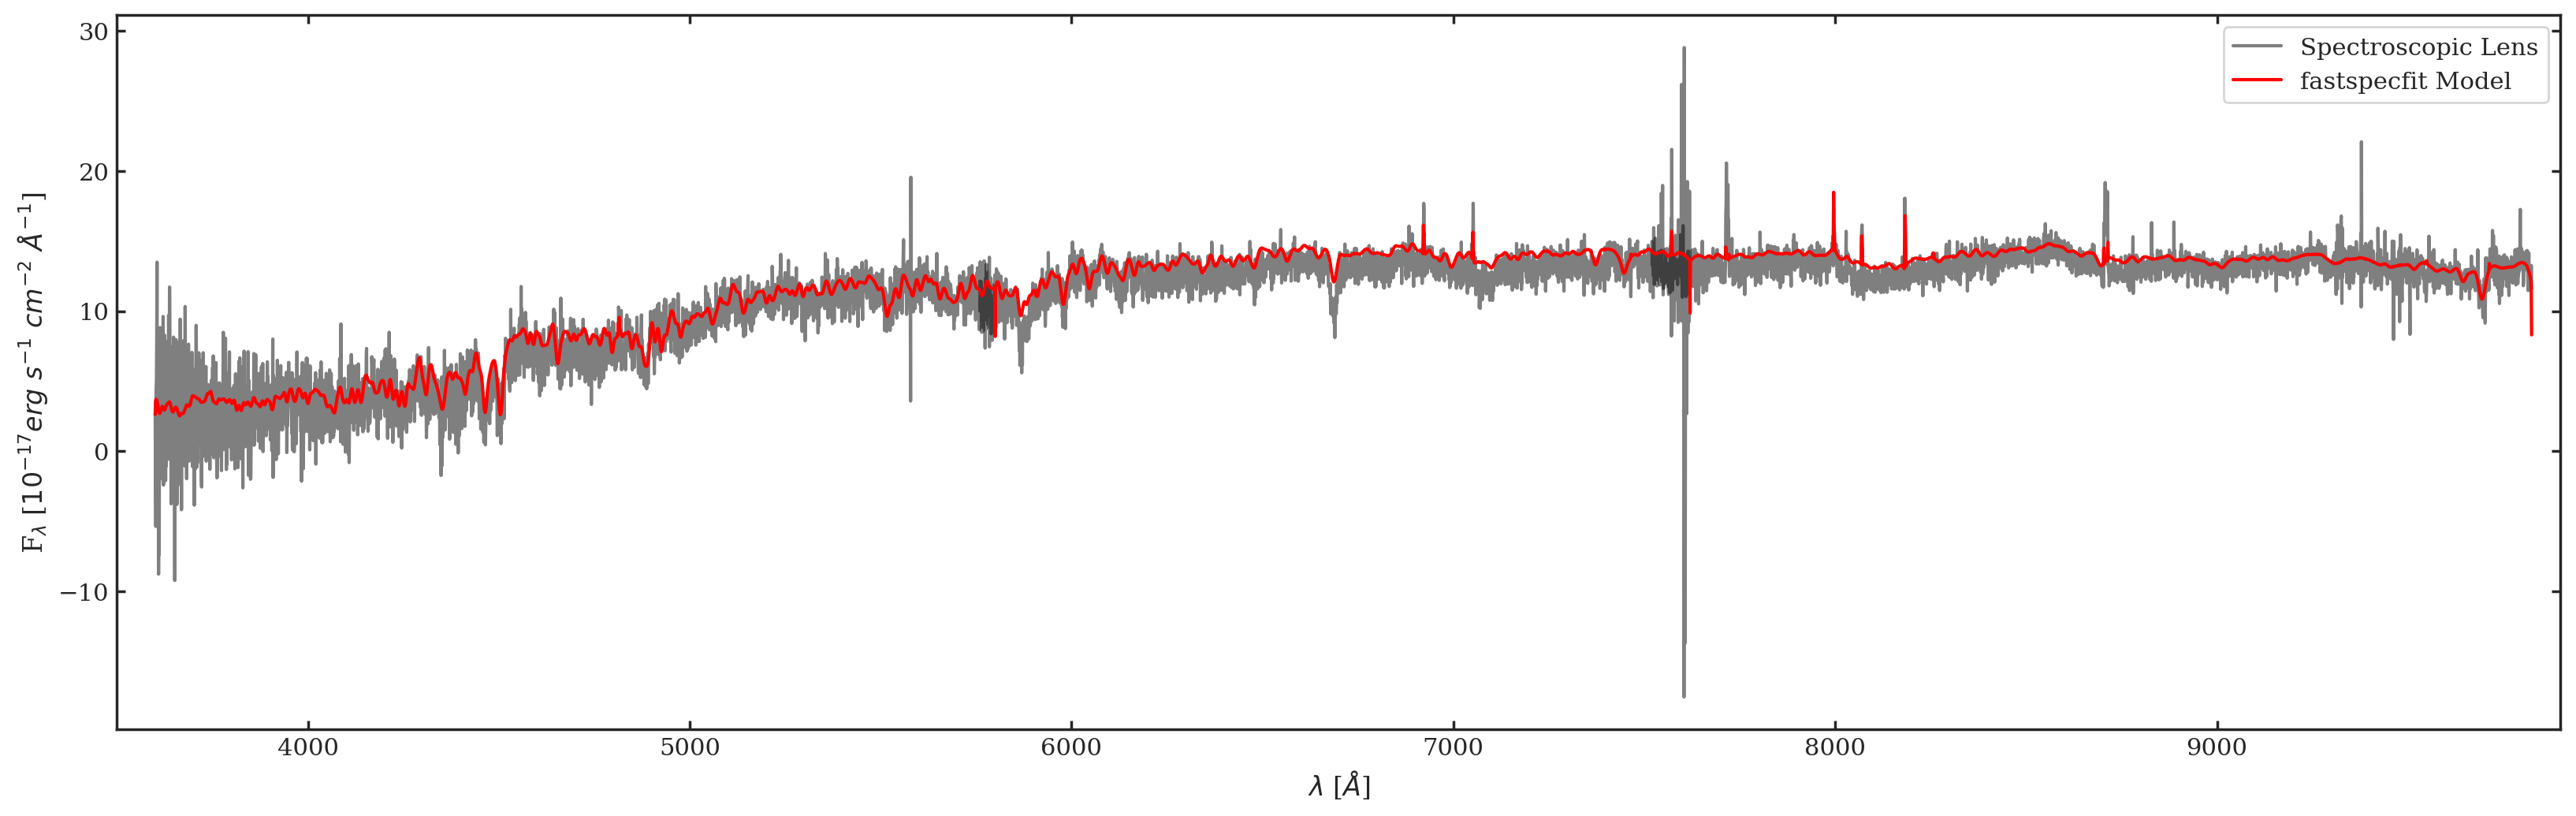

In [147]:
foregroundpath = os.path.join(outdir, 'fastspec-sv3-bright-25964-out.fits')
frontWave, frontFlux = plotFastspecModel(foregroundpath, orig)

# Subtract the spectra and plot the background spectrum

In [140]:
def subtract_spectra(coaddSpectra, frontFlux, frontWave):
    '''
    Subtract the foreground spectrum from the original coadded spectroscopic lens
    
    origSpec [DESI Spectra Object] : Spectra object with the original spectroscopic lens
    frontFlux [Array] : 1D array of the foreground object flux
    '''
    
    # combine flux from each original band to allow for subtraction
    # 
    waves = {}
    origFlux = {}
    backFlux = {}
    
    bands = ['b', 'r', 'z']
    for ii, band in enumerate(bands[:-1]):
        
        wave = coaddSpec.wave[band]
        flux = coaddSpec.flux[band][0]
        nextwavemin = min(coaddSpec.wave[bands[ii+1]])
        
        goodIdxs = np.where(wave < nextwavemin)[0]
        waves[band] = wave[goodIdxs]
        origFlux[band] = flux[goodIdxs]
    
    waves[bands[-1]] = coaddSpec.wave[bands[-1]]
    origFlux[bands[-1]] = coaddSpec.flux[bands[-1]][0]
    
    for band in bands:
        
        maxWave = max(waves[band])
        minWave = min(waves[band])
        goodWaves = np.where((frontWave <= maxWave) * (frontWave >= minWave))[0]
        
        backFlux[band] = origFlux[band] - frontFlux[goodWaves]       
    
    return waves, backFlux

In [142]:
wave, backFlux = subtract_spectra(coaddSpec, frontFlux, frontWave)

{'b': array([ 0.10293603, -5.08343041, -9.06241584, ..., -1.84168911,
        -2.87853432, -0.03641033]),
 'r': array([ 0.66209793, -1.42931557, -0.4635725 , ..., -0.16678524,
        -2.31236267, -2.39185905]),
 'z': array([ 0.71577835, -0.96224308, -0.50601196, ..., -0.15939331,
         1.84971905,  3.30018616])}

In [93]:
def plotSpectrum(wave, flux, ax=None, smooth=True, **kwargs):
    '''
    Plot a spectrum from the wavelength and flux arrays
    
    wave [Array] : array of the wavelengths
    flux [Array] : array of fluxes
    ax [Matplotlib Axes] : Existing Matplotlib axes object to plot on, default = None 
    '''
    
    from astropy.convolution import convolve, Gaussian1DKernel
    
    if not ax:
        fig, ax = plt.subplots(figsize=(20,6))
        
    ax.plot(wave, flux, label='Spectrum', **kwargs)
    ax.set_xlim([3500, 9900])
    ax.set_xlabel('$\lambda$ [$\AA$]')
    ax.set_ylabel('F$_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
    
    # smooth if requested
    if smooth:
        ax.plot(wave, convolve(flux, Gaussian1DKernel(3)), color = 'k', label='Smooth Spectrum')
        
    ax.legend()
    

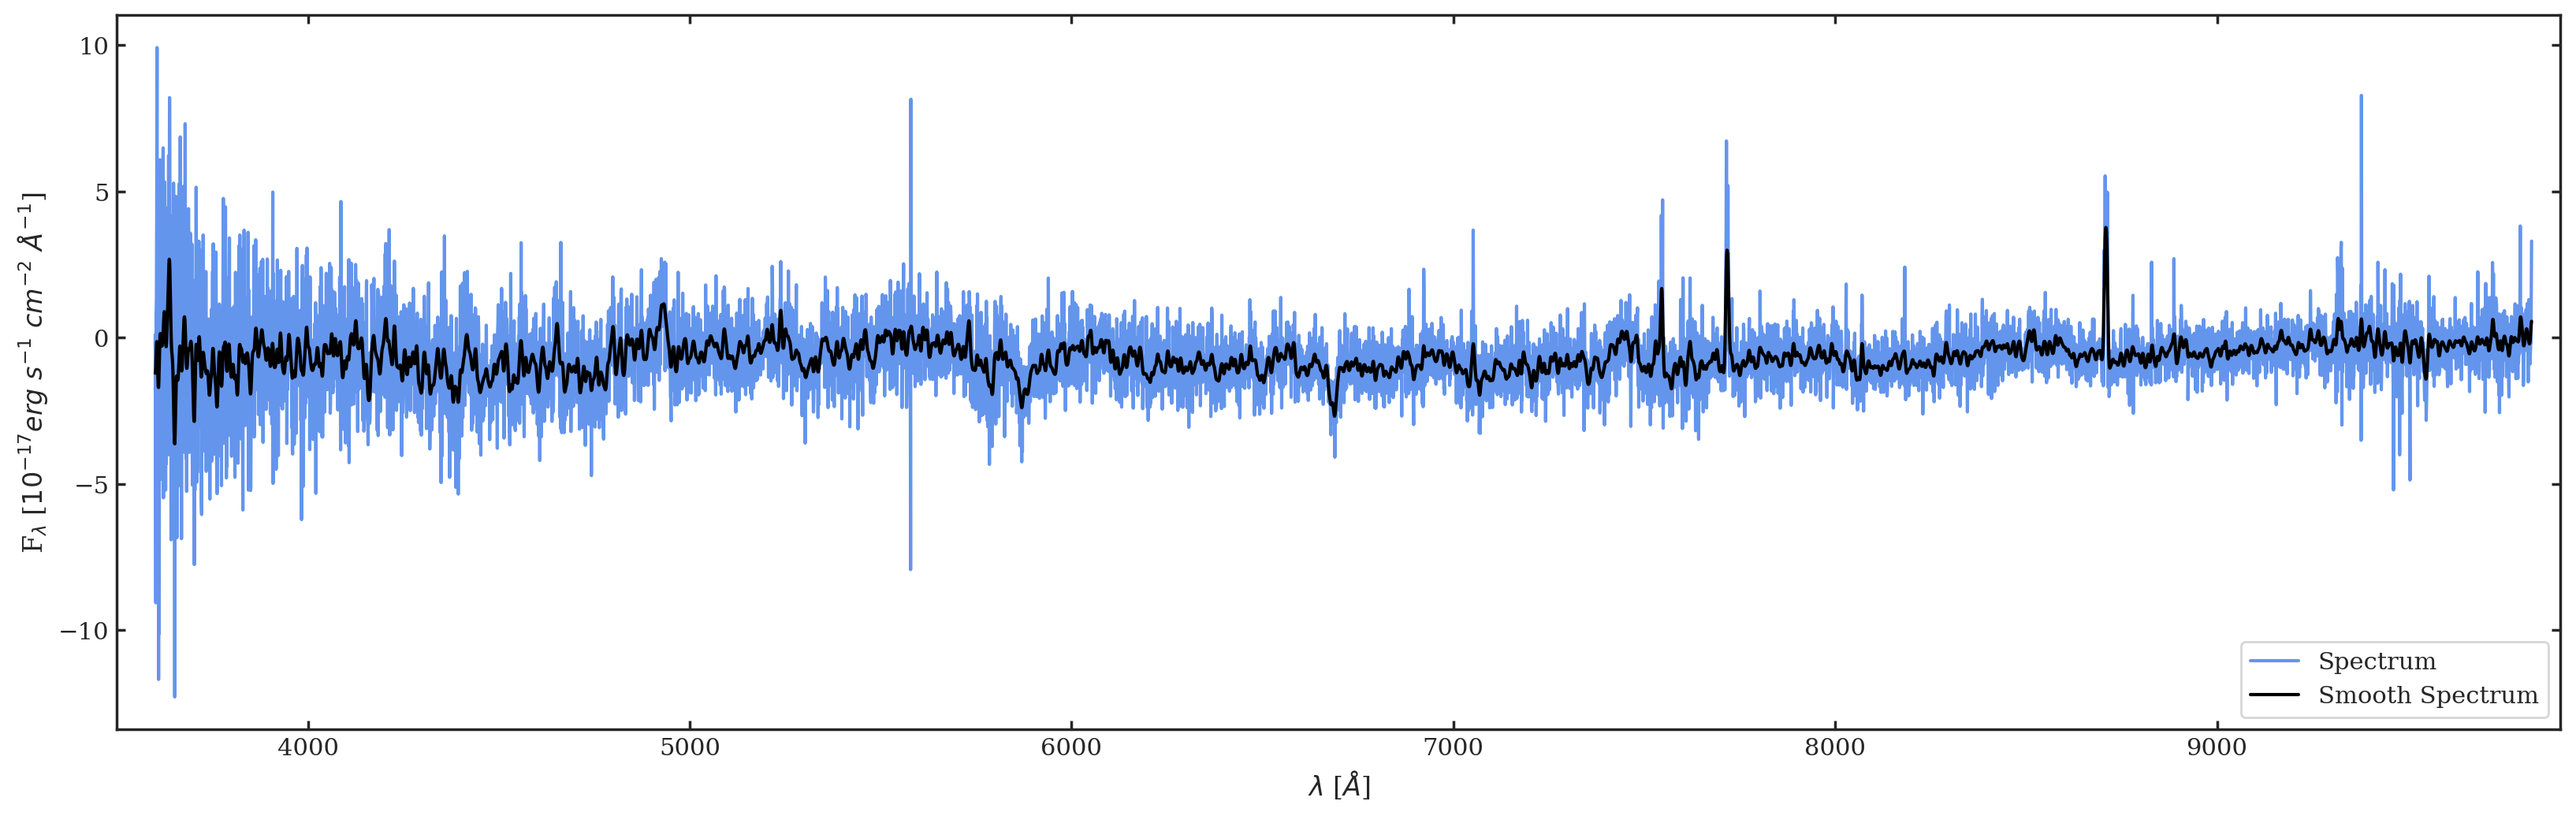

In [94]:
plotSpectrum(wave, backFlux, color='cornflowerblue')

In [95]:
def wrap_redrock(info, mp=1, prefix='lenssource'):
    """Simple wrapper on redrock given a simulation table."""

    from redrock.external.desi import rrdesi

    os.environ['OMP_NUM_THREADS'] = '1'

    nchunk = len(set(info['CHUNK']))
    zbestfiles = []

    for ichunk in set(info['CHUNK']):
        specfile = '{}-spectra-chunk{:03d}.fits'.format(prefix, ichunk)
        zbestfile = specfile.replace('-spectra-', '-zbest-')
        rrfile = zbestfile.replace('.fits', '.h5')
        if os.path.isfile(rrfile):
            os.remove(rrfile)
        zbestfiles.append(zbestfile)
        print('Writing redshifts for chunk {}/{} to {}'.format(ichunk, nchunk-1, zbestfile))

        rrdesi(options=['--zbest', zbestfile, '--mp', str(mp), '--output', rrfile, specfile])

    # Gather up all the results and write out a summary table.    
    zbest = Table(np.hstack([fitsio.read(zbestfile) for zbestfile in zbestfiles]))
    zbest = zbest[np.argsort(zbest['TARGETID'])]

    infofile = '{}-zbest.fits'.format(prefix)
    print('Writing {} redshifts to {}'.format(len(zbest), infofile))
    zbest.write(infofile, overwrite=True)

    return zbest